# Triplet ß-VAE on OPG

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, glob
import os.path as osp
import pandas as pd
import numpy as np
import sys

# reload my utilities at every cell execution 
%load_ext autoreload
%autoreload 2
# get absolute path of module (root)
module_path = os.path.abspath(os.path.join('../src'))

# add to PYTHONPATH
if module_path not in sys.path:
    sys.path.append(module_path)
    #print(sys.path)

# import module
#from networks import TripletNetwork
from tripletVAE import TripletVAE
from data_generator import TripletGenerator

In [3]:
#tvae = TripletVAE(input_shape=(128, 256, 1))
# r = np.random.random((1, 128, 256, 1))
# p = np.random.random((1, 128, 256, 1))
# n = np.random.random((1, 128, 256, 1))
# preds = tvae.model.predict([r,p,n])
# for pred in preds:
#     print(pred.shape)
#history = tvae.model.fit([r,p,n], batch_size=1)
# history.history['loss']

## Load image data + annotations

In [4]:
h, w = 128, 256
data_folder = '../data'
df_filename = '../data/df/strategical_clean_df.csv'

In [5]:
df = pd.read_csv(df_filename)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.head()


Unnamed: 0  Unnamed: 0.1  Aspect ratio  Channels  \
10212       12310         12310      2.041558         1   
13762       16654         16654      1.906250         1   
1112         1346          1346      1.906250         3   
891          1086          1086      1.906250         1   
6915         8314          8314      1.906250         1   

                                 Filename  Height  Height metric  Orientation  \
10212  B0A9E23EA9100C46C4637447CCB27F.tif    1540      13.860139            4   
13762  82223F6327F77222211F4BA78469F0.tif    1280      13.824387            4   
1112   C87B02841F248E6ED9F3BB8136F5B4.tif    1280      33.862434            1   
891    1965AB8B6327119CE94FBE8E26515F.tif    1280      13.824387            4   
6915   E6E7D4A8AFC1C8E385C88172BD4A5D.tif    1280      13.824387            4   

       Width  Width metric                              ID      DWID  \
10212   3144     28.296283  A588102C47AB63EB8CDD2D8803B3EA  128060.0   
13762   2440     26.352738  8F1F2F3B5B643B26DA19C9F40DF300  237330.0   
1112    2440     64.550265  7BA29B57693B6C91523068B3C0F58D  247905.0   
891     2440     26.352738  35178C221747452BAC28E860F63F74  147931.0   
6915    2440     26.352738  1BEB900A7500C40680484C458F7066  164770.0   

           oldDWID    Age Sex Type  Region                     OldFile  \
10212       128060  294.0   M   XP     1.0  P_0180\P_018015\047813.TIF   
13762  DW000237330  288.0   M   XP     1.0  P_0771\P_077189\359353.TIF   
1112   DW000247905  152.0   W   XP     1.0  P_0829\P_082958\401490.TIF   
891         147931  276.0   M   XP     1.0  P_0216\P_021688\061600.TIF   
6915   DW000164770  140.0   M   XP     1.0  P_0371\P_037182\295123.TIF   

                                                   Paths  
10212  /data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/data/B...  
13762  /data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/data/8...  
1112   /data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/data/C...  
891    /data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/data/1...  
6915   /data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/data/E...

# Data generator

### Compute pairwise distances for age

In [6]:
x = df_train['Age'].values
x = x[..., np.newaxis] # make 2D

# compute pairwise distances
from sklearn.metrics.pairwise import pairwise_distances # multithreaded, BUT SOMETIMES DOES NOT RETURN THE WHOLE MATRIX!!
pdist_age = pairwise_distances(x, n_jobs=-1).astype(np.float16)
#from scipy.spatial.distance import squareform, pdist # single threaded
#pdist_age = squareform(pdist(x, metric='euclidean'))

In [7]:
#plt.matshow(pdist_age)
#plt.show()

In [8]:
batch_size = 12
#fraction_test = 0.25
#train_df, test_df  = np.split(df, [int(len(df)*(1.0-fraction_test))], axis=0)
#print(len(train_df), len(test_df))
triplet_generator = TripletGenerator(dataframe      = df_train, 
                          distance_matrices = [pdist_age],
                          batch_size        = batch_size, 
                          data_folder       = data_folder,
                          augmentation      = True,
                          positive_quantile = 0.02,
                          negative_quantile = 0.05,
                          negative_quantile_max = 0.50,
                          verbose           = False)
triplet_generator

Image folder : ../data
Length of data frame: 16411
Number of distance matrices: 1
Positive quantile: 0.02
Negative quantile: 0.05
Negative quantile (maximum): 0.5
Augmentation: True
Image size: (128, 256)

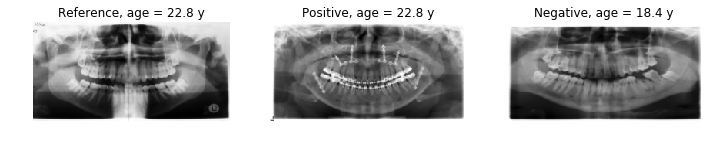

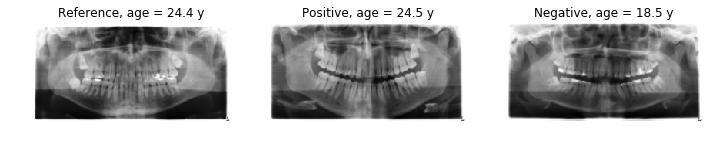

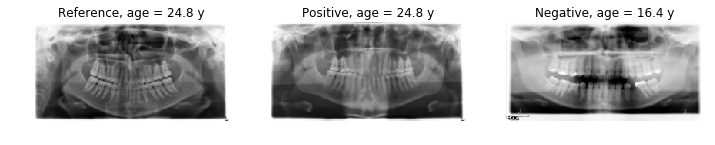

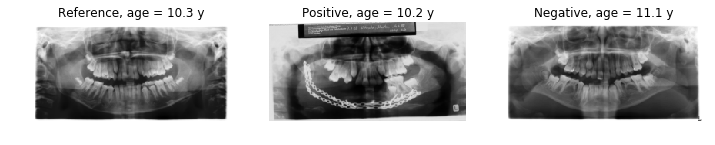

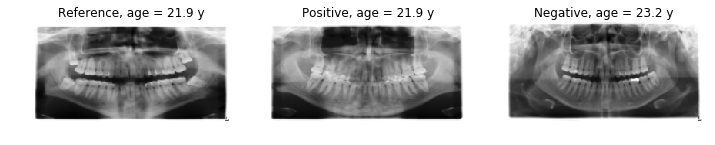

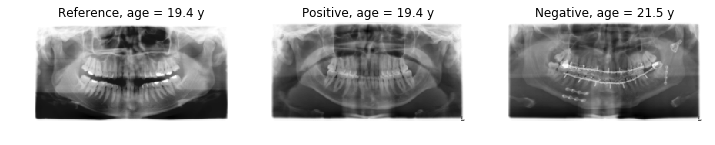

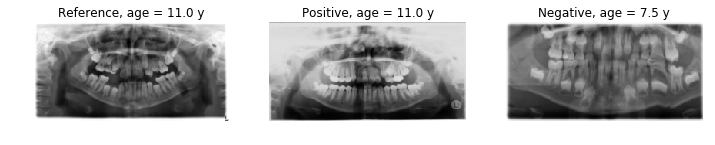

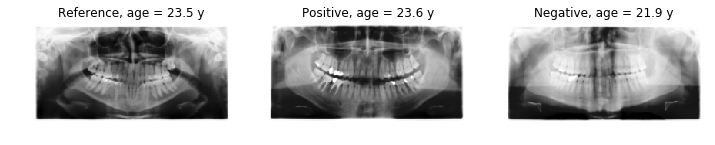

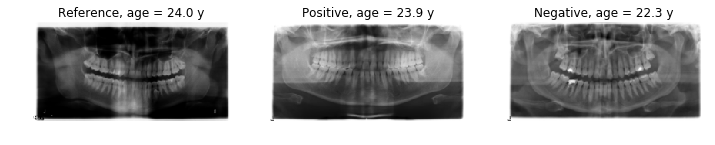

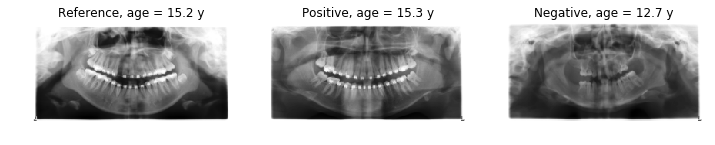

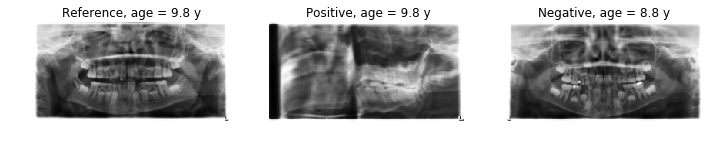

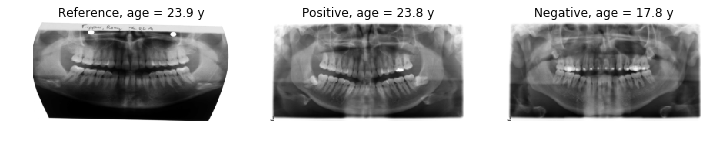

In [9]:
triplet_generator.plot_batch()

## VAE model

In [10]:
tvae = TripletVAE(input_shape=(128, 256, 1), 
                  latent_dim=128,
                  recon_loss='bce',
                  beta=1.0,
                  gamma=100.0,
                  margin=100.0)

encoder
decoder
vae
(?, 128, 256, 1)


In [11]:
tvae.load_weights()

/home/debacwa/Work/dl-opg-triplet/src/tripletVAE.py:205: UserWarning: Weights file ../../output/models/TripletVAE/encoder.h5 not found.
  warnings.warn(f'Weights file {out_fn_encoder} not found.')
/home/debacwa/Work/dl-opg-triplet/src/tripletVAE.py:211: UserWarning: Weights file ../../output/models/TripletVAE/decoder.h5 not found.
  warnings.warn(f'Weights file {out_fn_decoder} not found.')


In [12]:
#tvae.gamma = 1000.0
#tvae.margin = 100.0
#tvae.__dict__
print(tvae)

In [13]:
num_epochs = 20
tvae.fit(triplet_generator, 
         steps_per_epoch     = len(df_train)//batch_size,
         epochs              = num_epochs, 
         workers             = 8,
         use_multiprocessing = True,
         max_queue_size      = 128,
         initial_epoch = 0) 

Epoch 1/20


InvalidArgumentError: You must feed a value for placeholder tensor 'input_image_encoder_1' with dtype float and shape [?,128,256,1]
	 [[{{node input_image_encoder_1}} = Placeholder[dtype=DT_FLOAT, shape=[?,128,256,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node mul_12/_655}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7290_mul_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

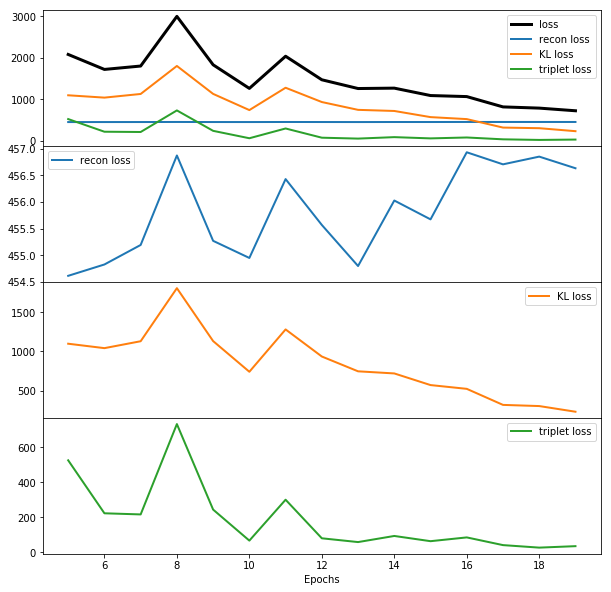

In [310]:
tvae.plot_history(start=5)

Save weights of encoder and decoder models

In [341]:
tvae.save_weights(output_folder='../output/models')

# Image retrieval 

We use nearest neighbor search to find similar images.

First, we do a forward pass on the training set (which is used as the "atlas") and we learn a nearest neighbor seach algorithm on the resulting "embedding codes".

In [311]:
from nearest_neighbors import NearestNeighbor
nn = NearestNeighbor(model=tvae, 
               df=df_train,
               image_folder=data_folder,
               h=h,
               w=w)
nn.fit(n_neighbors=128, radius=5.0, algorithm='auto', metric='euclidean')

Next, we visualize the latents and the embedding codes in a number of ways.

Here, we look at the standard deviation of the various latents. The latents that strongly deviate from zero are more informative. 

This provides information on how long the embedding code should be (`latent_dim`). 

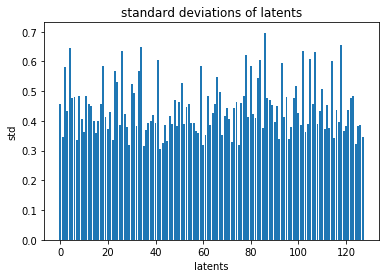

In [312]:
nn.plot_latents()

We can also project the embedding codes onto a 2D plane using UMAP. This provides a global view of the structure of the embedding space. Here, we colorcode it with the patients age.

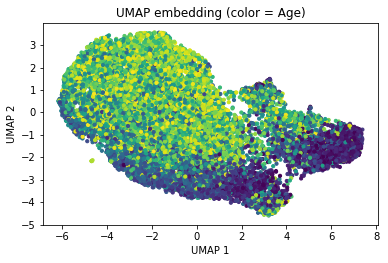

In [313]:
nn.plot_embedding(n_components=2, images=False, size=10)

We can visualize the same space using the original images instead of colored points.

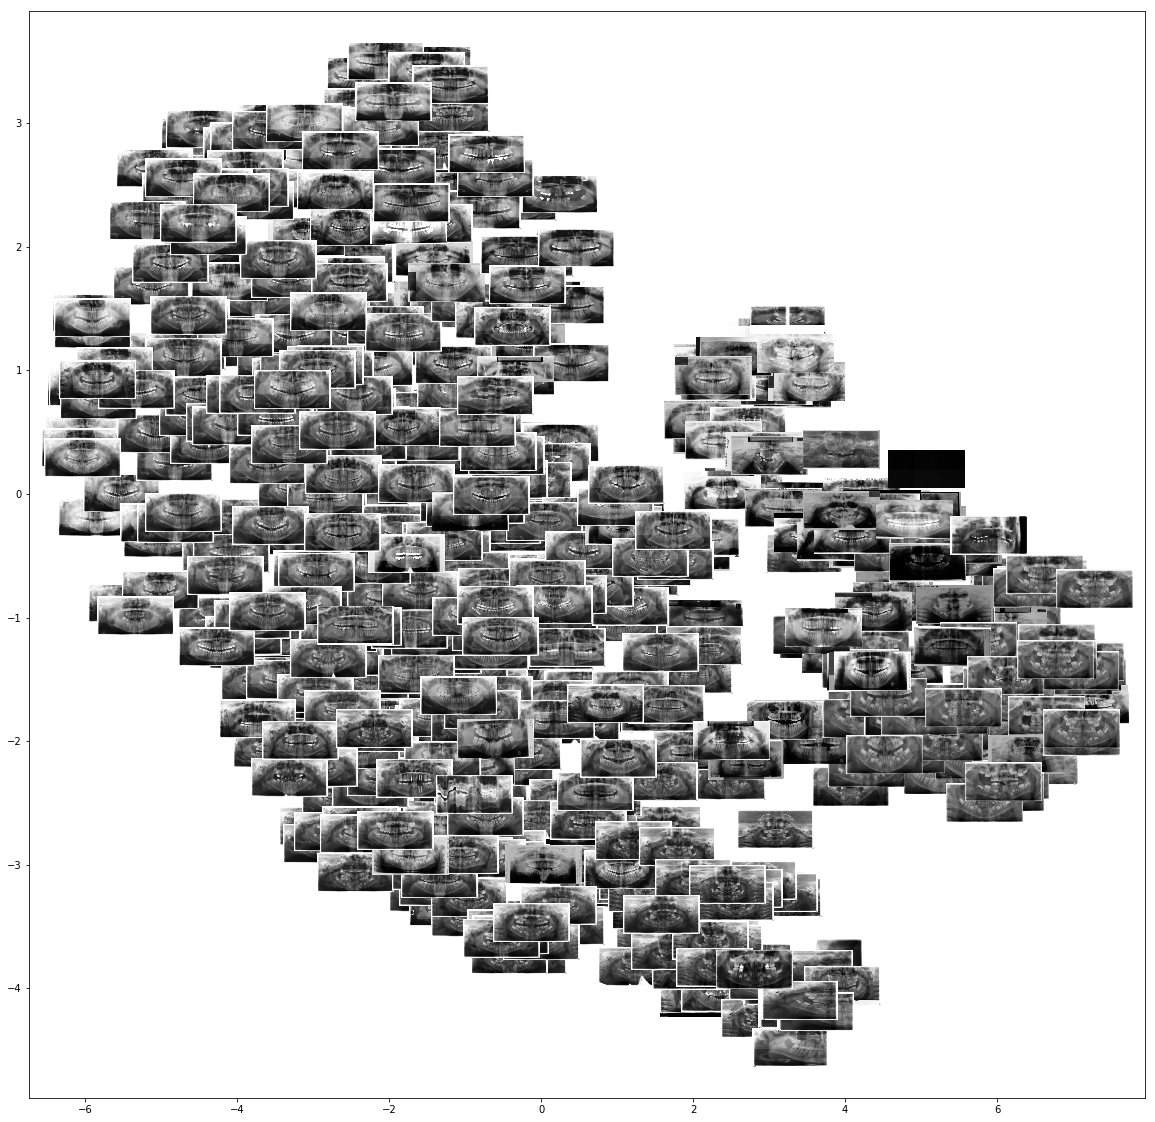

In [314]:
nn.plot_embedding(images=True, max_num_images=1024, size=0.3)

## Image retrieval and age estimation

Now we are ready to to perform age estimation, based on images. 

Here, we take a sample image from the test set (not seen during training) and use it as a query image. The function `get_knn()` returns the mean and std of the ages of the `k` nearest neighbors.

True age: 11.9 y


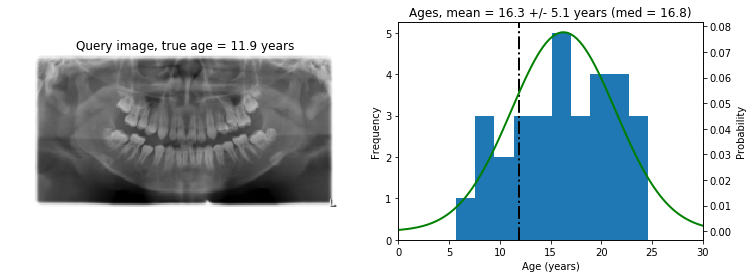

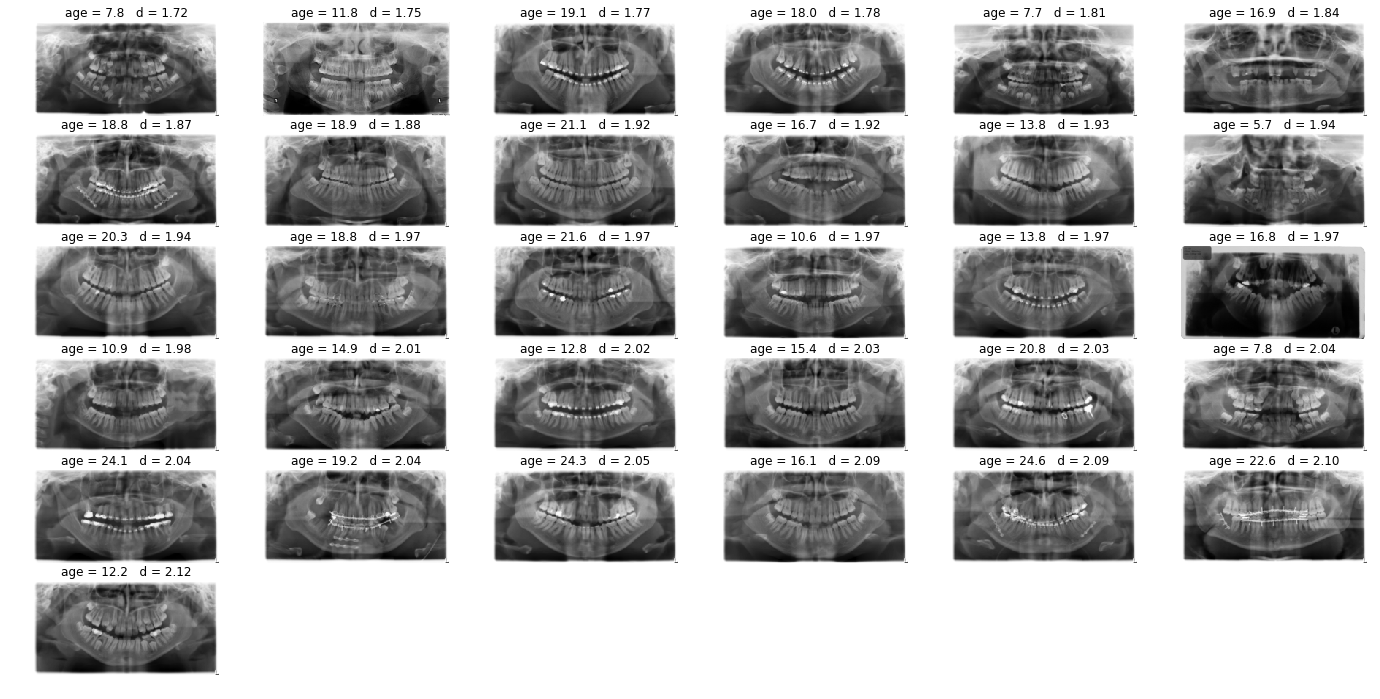

(16.26075268817204, 16.833333333333332, 5.135299421679946, 0.05431947112137564)

In [336]:
query = df_test.sample(n=1)
query_image_fn = query['Filename'].values[0]
query_age_true = query['Age'].values[0]
print(f"True age: {query_age_true / 12:.1f} y")
nn.get_knn(query_image_fn=query_image_fn, k=32, query_age_true=query_age_true, plot=True)

## Perform age estimation for all test images

In [337]:
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

results = []

for i, query in tqdm(df_test.iterrows(), total=len(df_test)):
    #print(query['Filename'], query['Age']/12)
    query_image_fn = query['Filename']
    query_age_true = query['Age']
    pred_age_mean, pred_age_median, pred_age_std, probability = \
        nn.get_knn(query_image_fn=query_image_fn,
                   k=64, 
                   query_age_true=query_age_true, 
                   plot=False)
    #print(pred_age_mean, pred_age_std)
    results.append({'Filename':query_image_fn, 
                    'Age true': query_age_true/12, 
                    'Age pred mean': pred_age_mean,
                    'Age pred std': pred_age_std,
                    'Age pred median': pred_age_median,
                    'Probability': probability})
df_results = pd.DataFrame(results)
df_results.head()

Age pred mean  Age pred median  Age pred std   Age true  \
0      11.480159        10.083333      4.722029  23.583333   
1      15.199735        14.666667      6.227456  22.416667   
2      17.380952        17.083333      4.039125  13.000000   
3      19.187831        19.166667      3.160219  13.000000   
4      19.411376        19.416667      3.070342  22.666667   

                             Filename  Probability  
0  A45BA3C2B9553C8E181F4D1B9382BE.tif     0.003164  
1  EEBC817548D942118C4C340628DDB1.tif     0.032731  
2  55472FED8D1EF5F28F8419DC860395.tif     0.054849  
3  9CB64BAFC0B953F453DB0539814BCE.tif     0.018564  
4  11E79A1A0DAAFB899E9CB48D34A0EC.tif     0.074067

### Visualization of results, and quantification of prediction accuracy

Text(0, 0.5, 'Predicted age (years)')

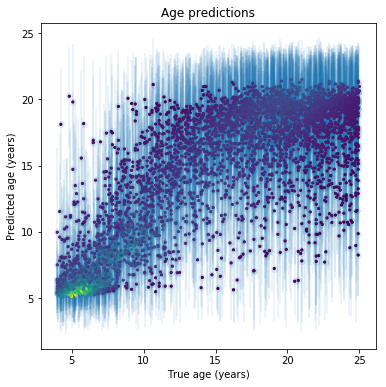

In [338]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.errorbar(df_results['Age true'], df_results['Age pred mean'], yerr=df_results['Age pred std'], fmt='o', alpha=0.1)
ax.scatter(df_results['Age true'], df_results['Age pred mean'], s=5, c=df_results['Probability'], zorder=10)
ax.set_title('Age predictions')
ax.set_xlabel('True age (years)')
ax.set_ylabel('Predicted age (years)')

Text(0, 0.5, 'Probability')

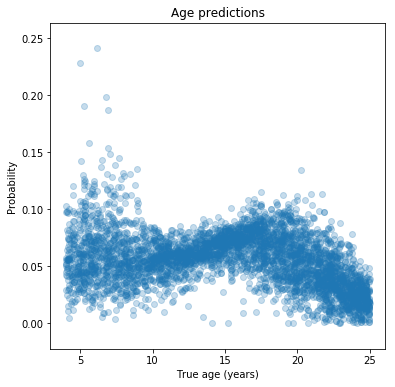

In [288]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(df_results['Age true'], df_results['Probability'], alpha=0.25, zorder=10)
ax.set_title('Age predictions')
ax.set_xlabel('True age (years)')
ax.set_ylabel('Probability')

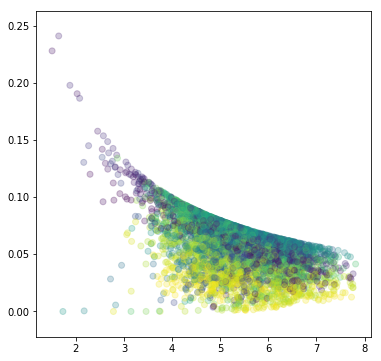

In [289]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(df_results['Age pred std'], df_results['Probability'], alpha=0.25, c=df_results['Age true'], zorder=10)


----
----

## Cluster the embeddings

In [80]:
#!pip install hdbscan
import hdbscan

# HDBSCAN clustering (in original hi-dim space)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(embedding)

# HDBSCAN clustering in 2D UMAP space
#clusterer = hdbscan.HDBSCAN(min_cluster_size=5).fit(emb_2d)


NameError: name 'embedding' is not defined

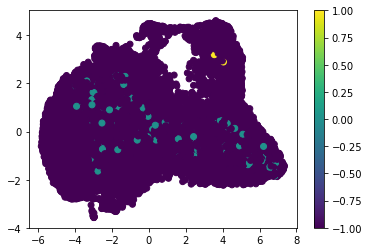

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(*emb_2d.T, c=clusterer.labels_)
plt.colorbar()
plt.show()

#plt.scatter(*emb_2d.T, c=data_y)
#plt.colorbar()
#plt.show()

In [ ]:
unique_labels, counts = np.unique( clusterer.labels_, return_counts=True )
print(unique_labels)
print(counts)

## Visualize clusters

In [ ]:
clusters = []
for label in unique_labels:
    indices = np.where(clusterer.labels_ == label)[0]
    #print(indices)
    clusters.append( x_train[indices] )

In [ ]:

for l, c in zip(unique_labels, clusters):
  
  print(f'=== cluster {l} ===')
  fig, ax = plt.subplots(4,4,figsize=(10,10))
  ax = ax.flatten()
  
  for i in range(16):
    if i < len(c):
      ax[i].imshow(np.squeeze(c[i]), cmap='gray')
      ax[i].axis('off')
    else:
      ax[i].set_visible(False)
    
  plt.show()
  